In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from glob import glob
from data import RivetPatchesDataset, RivetsAnnoAutoEncoder
import core
from torch.utils.data import DataLoader
from torchvision import transforms
from autoencoder import Autoencoder
from exp_summary import setup_final_summary, save_losses, generate_exp_name
import matplotlib.pyplot as plt
import numpy as np
import sys
import random 

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
data_dir = "/mnt/data/luftronix/luftr_data/anno_data/"
files = glob('{}/*.png'.format(data_dir))
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
model = Autoencoder()

transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = RivetsAnnoAutoEncoder("ds_yak_20190416_nau_fuselage-20190822_train.json", data_dir, "ds_yak_20190416_nau_fuselage", 16, transform)
val_dataset = RivetsAnnoAutoEncoder("ds_yak_20190416_nau_fuselage-20190822_val.json", data_dir, "ds_yak_20190416_nau_fuselage", 16, transform)
    

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=1, 
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset, 
                          batch_size=1, 
                          shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [3]:
normal_out = sys.stdout
exp_dir, assets_dir, log_file = setup_final_summary("./")
print(log_file)
log = open(log_file, "a")
sys.stdout = log

./experiments/Sparrow/log.txt
KKKE ./experiments/Sparrow/log.txt


In [4]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 1
for e in range(1, epochs+1):
    train_loss = 0.0  # monitor training loss
    for data in train_loader:
        images = data                        # we are just intrested in just images
        # no need to flatten images
        optimizer.zero_grad()
        images = images.squeeze()
        outputs = model(images)                  # forward pass: compute predicted outputs 
        loss = criterion(outputs, images)        # calculate the loss
        loss.backward()                          # backward pass
        optimizer.step()                         # perform optimization step
        train_loss += loss.item()*images.size(0) # update running training loss
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {}'.format(e),
        '\tTraining Loss: {:.4f}'.format(train_loss))

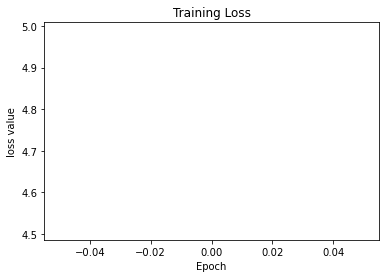

In [5]:
save_losses(log_file, assets_dir)

In [ ]:
def calculateDistance(i1, i2):
    return np.sum((i1-i2)**2)

In [ ]:
dataiter = iter(val_loader)
images = dataiter.next()
images = images.squeeze()
output = model(images)
images = images.numpy()                    
output = output.view(16, 3, 32, 32)# resizing output
output = output.detach().numpy()# use detach when it's an output that requires_grad
print("Image distances: ", file=LOG_FILE)
print(calculateDistance(images, output), file=LOG_FILE)
save_visual_examples(images, output, assets_dir)
# plot the first ten input images and then reconstructed images
